# 3.6 human-in-the-loop: 사람이 Agent와 소통하는 방법

- AI는 100%의 정확도를 보장하지 않기 때문에, 경우에 따라 사람의 개입이 필요합니다
- LangGraph의 [`interrupt`](https://langchain-ai.github.io/langgraph/cloud/how-tos/interrupt_concurrent/) 를 사용하여 사람의 개입을 처리할 수 있습니다

In [1]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

True

In [2]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

llm = ChatOpenAI(model="gpt-4o-mini")
# llm = ChatOllama(model="llama3.1")

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a+b

@tool
def mul(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a*b

```python
tools = [add, mul, retriever_tool] + search_tools + arxiv_tools + gmail_tools
```

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools.retriever import create_retriever_tool

collection_name = "real_estate_tax"
embedding_function = HuggingFaceEmbeddings(model="BAAI/bge-m3")
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_function,
    persist_directory="./chroma"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="real_estate_tax_retriever",
    description="부동산 세금 정보 검색기"
)
retriever_tool

StructuredTool(name='real_estate_tax_retriever', description='부동산 세금 정보 검색기', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x00000202025F63E0>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x00000202025F7D80>)

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_tavily import TavilySearch

search_tools = [
    DuckDuckGoSearchRun(),
    TavilySearch(
        max_results=3,
        topic="general",
        include_answer=True,
        include_raw_content=True,
        include_images=True,
        include_image_descriptions=True,
        search_depth="advanced",
    )
]
search_tools

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


[DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text')),
 TavilySearch(search_depth='advanced', include_images=True, max_results=3, topic='general', include_answer=True, include_raw_content=True, include_image_descriptions=True, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))]

In [6]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

arxiv_tools = [
    ArxivQueryRun(api_wrapper=ArxivAPIWrapper(top_k_results=3)),
    WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=3)),
]
arxiv_tools

[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000)),
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\limjangmook\\Desktop\\ANSWER_25\\inflearn-langgraph-agent\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))]

In [7]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import get_google_credentials, build_gmail_service

credentials = get_google_credentials(
    scopes=["https://mail.google.com/"],
    token_file="./google/gmail_token.json",
    client_secrets_file="./google/gmail_credentials.json"
)
api_resource = build_gmail_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tools = gmail_toolkit.get_tools()
gmail_tools

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x000002020478B680>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x000002020478B680>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x000002020478B680>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x000002020478B680>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x000002020478B680>)]

In [8]:
from langgraph.prebuilt import ToolNode

tools = [add, mul, retriever_tool] + search_tools + arxiv_tools + gmail_tools
tool_node = ToolNode(tools=tools)
llm_with_tools = llm.bind_tools(tools=tools)

In [9]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

workflow = StateGraph(AgentState)

In [10]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState) -> AgentState:
    """
    이 에이전트 함수는 주어진 state에서 이전 요약과 메시지를 가져와 LLM과 도구를 사용하여 응답 메시지를 생성합니다.
    Args:
        state (MessagesState): 이전 요약과 메시지 기록을 포함하는 state
    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state
    """
    messages = state["messages"]
    summary = state["summary"]

    if summary != "":
        messages = [SystemMessage(content=f"이전 대화 기록 요약입니다: {summary}")] + messages
    
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

- `interrupt`에는 사용자에게 보여주고자 하는 메시지를 dictionary 형태로 작성합니다

In [11]:
from typing import Literal
from langgraph.types import Command, interrupt

def human_review(state: AgentState) -> Command[Literal["tools", "agent"]]:
    """
    human_review node는 LLM의 도구 호출에 대해 사람의 검토를 요청합니다.
    Args:
        state (AgentState): 메시지 기록을 포함하는 state
    Returns:
        Command: 다음 node로 이동하기 위한 Command를 반환합니다.
    """
    messages = state["messages"]
    tool_call = messages[-1].tool_calls[-1]

    review_interrupt = interrupt({
        "question": " 이렇게 진행하면 될까요?",
        "tool_call": tool_call,
    })
    review_action = review_interrupt["action"]  # "continue", "update_args", "update_tool"
    review_data = review_interrupt.get("data", None)

    if review_action == "continue":
        # 에이전트의 판단이 맞다면, 도구를 사용하기 위해 아무것도 수정하지 않고 "tools" 노드로 이동합니다
        return Command(goto="tools")
    
    if review_action == "update_args":
        # 도구를 더 효율적으로 사용하기 위해 `AIMessage`의 "tool_calls" 필드를 업데이트합니다
        updated_ai_message = {
            "id": messages[-1].id,
            "role": "ai",
            "content": messages[-1].content,
            "tool_calls": [{
                "id": tool_call["id"],
                "name": tool_call["name"],
                "args": review_data,
            }]
        }
        return Command(goto="tools", update={"messages": [updated_ai_message]})

    if review_action == "update_tool":
        # 다른 도구를 사용하기 위해 `ToolMessage`를 업데이트합니다 
        updated_tool_message = {
            "tool_call_id": tool_call["id"],
            "name": tool_call["name"],
            "role": "tool",
            "content": review_data,
        }
        return Command(goto="agent", update={"messages": [updated_tool_message]})

In [12]:
def summarize_messages(state: AgentState):
    """
    주어진 state의 메시지를 요약합니다.
    Args:
        state (AgentState): 요약과 메시지를 포함하는 state
    Returns:
        AgentState: 요약된 메시지를 포함하는 state
    """
    messages = state["messages"]
    summary = state["summary"]

    if summary == "":
        summary_prompt = f"""아래 대화 기록을 요약해 주세요:
            chat_history: {messages}"""
    else:
        summary_prompt = f"""이전 요약을 포함해서, 아래 대화 기록을 요약해 주세요:
            chat_history: {messages}
            summary: {summary}"""
    
    response = llm_with_tools.invoke(summary_prompt)
    return {"summary": response.content}

In [13]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState):
    """
    주어진 state에서 오래된 메시지를 삭제합니다.
    Args:
        state (AgentState): 메시지를 포함하는 state
    Returns:
        AgentState: 삭제된 메시지를 포함하는 새로운 state
    """
    messages = state["messages"]
    deleted_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    return {"messages": deleted_messages}

In [14]:
def should_continue(state: AgentState) -> Literal["human_review", "summarize_messages"]:
    """
    주어진 state에 따라 다음 단계로 진행할지 결정합니다.
    Args:
        state (AgentState): 메시지와 도구 호출 정보를 포함하는 state
    Returns:
        Literal["human_review", "summarize_messages"]: 다음 단계로 "human_review" or "summarize_messages"를 반환합니다.
    """
    messages = state["messages"]
    if messages[-1].tool_calls:
        return "human_review"
    return "summarize_messages"

- `node`를 추가하고 `edge`로 연결합니다

In [15]:
from langgraph.graph import START, END

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)
workflow.add_node(human_review)
workflow.add_node(summarize_messages)
workflow.add_node(delete_messages)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["human_review", "summarize_messages"])
workflow.add_edge("tools", "agent")
workflow.add_edge("summarize_messages", "delete_messages")
workflow.add_edge("delete_messages", END)

- `interrupt`로 중단된 시점부터 다시 워크플로우를 재개하기 위해 `checkpointer`가 필요합니다

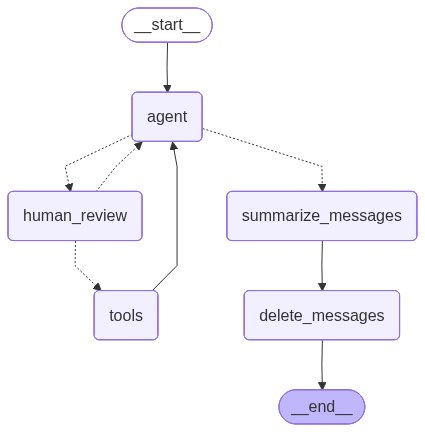

In [16]:
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image

checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
from langchain_core.messages import HumanMessage

config = {
    "configurable": {
        "thread_id": "summarize_paper"
    }
}

In [18]:
query = "LLM Survey 논문 검색해서 요약해 주세요"

for response in graph.stream(
    {"messages": [HumanMessage(query)], "summary": ""},
    config=config,
    stream_mode="values",
):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

LLM Survey 논문 검색해서 요약해 주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_mBmAGy4h9BqJxPRMkll3Lmpo)
 Call ID: call_mBmAGy4h9BqJxPRMkll3Lmpo
  Args:
    query: LLM Survey
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_mBmAGy4h9BqJxPRMkll3Lmpo)
 Call ID: call_mBmAGy4h9BqJxPRMkll3Lmpo
  Args:
    query: LLM Survey


In [19]:
graph.get_state(config).values["messages"]

[HumanMessage(content='LLM Survey 논문 검색해서 요약해 주세요', additional_kwargs={}, response_metadata={}, id='b726fd8c-cb9b-4fbf-90bd-a3b993d9b363'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 1940, 'total_tokens': 1956, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-Cqapj5unOf8VBzlvFVphL0gKdfB90', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b5496-0a1e-7e32-8c81-20819225b86d-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'LLM Survey'}, 'id': 'call_mBmAGy4h9BqJxPRMkll3Lmpo', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1940, 'output_tokens': 16, 'total_tokens': 1956

In [20]:
graph.get_state(config).values["messages"][-1].tool_calls[-1]

{'name': 'arxiv',
 'args': {'query': 'LLM Survey'},
 'id': 'call_mBmAGy4h9BqJxPRMkll3Lmpo',
 'type': 'tool_call'}

In [21]:
for response in graph.stream(
    Command(resume={"action": "update_tool", "data": "arxiv말고 web에서 검색해 주세요"}),
    config=config,
    stream_mode="updates",
):
    print(response)

{'human_review': {'messages': [{'tool_call_id': 'call_mBmAGy4h9BqJxPRMkll3Lmpo', 'name': 'arxiv', 'role': 'tool', 'content': 'arxiv말고 web에서 검색해 주세요'}]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1973, 'total_tokens': 1996, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1920}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-Cqapq1bDxKNE2P8XNVMW8Gb1WjWxD', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b5496-276c-70c2-949e-9d532d5e9261-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'LLM Survey', 'search_depth': 'advanced'}, 'id': 'call_afJIDcLuyfzldcrw3r6CqXzC', 'type': 'tool_call'}], usag

In [22]:
graph.get_state(config).values["messages"]

[HumanMessage(content='LLM Survey 논문 검색해서 요약해 주세요', additional_kwargs={}, response_metadata={}, id='b726fd8c-cb9b-4fbf-90bd-a3b993d9b363'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 1940, 'total_tokens': 1956, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-Cqapj5unOf8VBzlvFVphL0gKdfB90', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b5496-0a1e-7e32-8c81-20819225b86d-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'LLM Survey'}, 'id': 'call_mBmAGy4h9BqJxPRMkll3Lmpo', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1940, 'output_tokens': 16, 'total_tokens': 1956

In [23]:
graph.get_state(config).values["messages"][-1].tool_calls[-1]

{'name': 'tavily_search',
 'args': {'query': 'LLM Survey', 'search_depth': 'advanced'},
 'id': 'call_afJIDcLuyfzldcrw3r6CqXzC',
 'type': 'tool_call'}

In [24]:
for response in graph.stream(
    Command(resume={"action": "continue"}),
    config=config,
    stream_mode="updates",
):
    print(response)

{'human_review': None}
{'tools': {'messages': [ToolMessage(content='{"query": "LLM Survey", "follow_up_questions": null, "answer": "Large language models (LLMs) revolutionize AI development, with key advances in pre-training, adaptation, utilization, and evaluation. They assist in survey research by generating responses but cannot address sampling bias. A comprehensive survey collection exists, covering over 150 surveys on LLMs.", "images": [{"url": "https://pic1.zhimg.com/v2-b78c8a045bea1efdee800de108066cb0_r.jpg", "description": "The image compares in-context learning and chain-of-thought prompting with examples of mathematical reasoning questions, demonstrations, and test queries, illustrating their differences in approach."}, {"url": "https://pic3.zhimg.com/v2-8be80510e165e6de7f8d657dfbd09516_r.jpg", "description": "A colorful circular diagram categorizes aspects of large language model evaluation, including knowledge and capability, alignment evaluation, safety, robustness evaluat

In [25]:
graph.get_state(config).values["messages"]

[AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1973, 'total_tokens': 1996, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1920}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-Cqapq1bDxKNE2P8XNVMW8Gb1WjWxD', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b5496-276c-70c2-949e-9d532d5e9261-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'LLM Survey', 'search_depth': 'advanced'}, 'id': 'call_afJIDcLuyfzldcrw3r6CqXzC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1973, 'output_tokens': 23, 'total_tokens': 1996, 'input_token_details': {'audio': 0, 'cache_read': 1920}, 'output_token_details': {'audio': 0, 'reas